Aim - Generate System Matrix (in an Efficient Way)

In [130]:
import os
import tqdm
import uproot
import cupy as cp
import cupyx.scipy.sparse as cp_sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, lil_matrix, vstack, save_npz, csr_matrix, issparse

### Configuration Parameters

In [131]:
FILE_PATH = "system_matrix.root"
TREE_NAME = "Coincidences"
N_EVENTS_TO_PROCESS = 100000*1000 # Set to None to process all, or a number for testing

### Voxelization Parameters

In [132]:
VOXEL_PARAMS = {
    "x_min": -400, "x_max": 400, "nx": 64,
    "y_min": -400, "y_max": 400, "ny": 64,
    "z_min": -700, "z_max": 700, "nz": 64,
}

In [133]:
TOTAL_VOXELS = VOXEL_PARAMS["nx"] * VOXEL_PARAMS["ny"] * VOXEL_PARAMS["nz"]

In [134]:
print(TOTAL_VOXELS)

262144


### Sinogram Parameters

In [135]:
SINOGRAM_PARAMS = {
    "n_theta": 180,  # Number of angular bins
    "n_s": 128,      # Number of radial (detector) bins
    "s_min": -400.0, # Min value for sinogramS variable
    "s_max": 400.0,  # Max value for sinogramS variable
}

In [136]:
N_SINOGRAM_BINS_TOTAL = SINOGRAM_PARAMS["n_theta"] * SINOGRAM_PARAMS["n_s"]

In [137]:
print(N_SINOGRAM_BINS_TOTAL)

23040


### Helper Function - Assign Voxel Index

In [138]:
def assign_voxel_idx(x, y, z, x_min, x_max, nx, y_min, y_max, ny, z_min, z_max, nz):
    """
    Maps continuous 3D coordinates to a discrete 1D voxel index.
    Assumes x, y, z can be scalar or NumPy arrays.
    """
    # Normalize coordinates to [0, 1)
    xn = (x - x_min) / (x_max - x_min)
    yn = (y - y_min) / (y_max - y_min)
    zn = (z - z_min) / (z_max - z_min)

    # Scale to voxel grid and convert to integer indices
    xi = np.floor(xn * nx).astype(int)
    yi = np.floor(yn * ny).astype(int)
    zi = np.floor(zn * nz).astype(int)

    # Clamp indices to be within valid range [0, N-1]
    xi = np.clip(xi, 0, nx - 1)
    yi = np.clip(yi, 0, ny - 1)
    zi = np.clip(zi, 0, nz - 1)

    # Convert 3D voxel index (xi, yi, zi) to 1D linear index
    voxel_idx_1d = zi * (nx * ny) + yi * nx + xi
    return voxel_idx_1d

### 1. Load Data

In [139]:
branches_to_load = [
    # For filtering true events
    'comptonPhantom1', 'RayleighPhantom1',
    'comptonPhantom2', 'RayleighPhantom2',
    # For voxelization (source position of the annihilation)
    'sourcePosX1', 'sourcePosY1', 'sourcePosZ1',
    # For sinogram binning
    'sinogramTheta', 'sinogramS'
]

In [140]:
tree = uproot.open(FILE_PATH + ":" + TREE_NAME)

In [141]:
if N_EVENTS_TO_PROCESS is None:
    df_raw = tree.arrays(branches_to_load, library="pd")
else:
    df_raw = tree.arrays(branches_to_load, library="pd", entry_stop=N_EVENTS_TO_PROCESS)

In [142]:
print(f"Successfully loaded {len(df_raw)} events with {len(df_raw.columns)} branches.")

Successfully loaded 19481401 events with 9 branches.


(array([1198176., 1853274., 2120667., 2256652., 2311212., 2313208.,
        2255205., 2121689., 1853119., 1198199.]),
 array([-3.67859161e+02, -2.94288086e+02, -2.20717026e+02, -1.47145950e+02,
        -7.35748825e+01, -3.81469727e-03,  7.35672531e+01,  1.47138321e+02,
         2.20709396e+02,  2.94280457e+02,  3.67851532e+02]),
 <BarContainer object of 10 artists>)

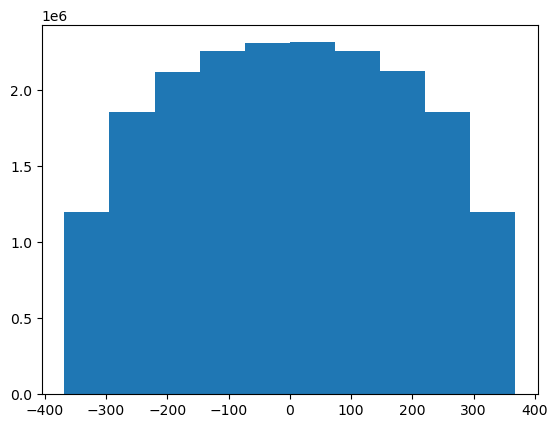

In [143]:
plt.hist(df_raw["sourcePosX1"])

### 2. Filter for True Events (no scattering)

In [103]:
df_true = df_raw[
    (df_raw['comptonPhantom1'] == 0) &
    (df_raw['RayleighPhantom1'] == 0) &
    (df_raw['comptonPhantom2'] == 0) &
    (df_raw['RayleighPhantom2'] == 0)
].copy() # Use .copy() to avoid SettingWithCopyWarning

In [104]:
print(f"Number of true events after filtering: {len(df_true)}")

Number of true events after filtering: 19367487


In [105]:
print(f"Number of removed events after filtering: {len(df_raw) - len(df_true)}")

Number of removed events after filtering: 113914


### 3. Voxelize Event Source Positions

In [144]:
x_pos = cp.array(df_true['sourcePosX1'].values)
y_pos = cp.array(df_true['sourcePosY1'].values)
z_pos = cp.array(df_true['sourcePosZ1'].values)

x_c = cp.clip(x_pos, VOXEL_PARAMS["x_min"], VOXEL_PARAMS["x_max"] - 1e-6)
y_c = cp.clip(y_pos, VOXEL_PARAMS["y_min"], VOXEL_PARAMS["y_max"] - 1e-6)
z_c = cp.clip(z_pos, VOXEL_PARAMS["z_min"], VOXEL_PARAMS["z_max"] - 1e-6)

xi = ((x_c - VOXEL_PARAMS["x_min"]) / (VOXEL_PARAMS["x_max"] - VOXEL_PARAMS["x_min"]) * VOXEL_PARAMS["nx"]).astype(cp.int32)
yi = ((y_c - VOXEL_PARAMS["y_min"]) / (VOXEL_PARAMS["y_max"] - VOXEL_PARAMS["y_min"]) * VOXEL_PARAMS["ny"]).astype(cp.int32)
zi = ((z_c - VOXEL_PARAMS["z_min"]) / (VOXEL_PARAMS["z_max"] - VOXEL_PARAMS["z_min"]) * VOXEL_PARAMS["nz"]).astype(cp.int32)

xi = cp.maximum(0, cp.minimum(VOXEL_PARAMS["nx"] - 1, xi))
yi = cp.maximum(0, cp.minimum(VOXEL_PARAMS["ny"] - 1, yi))
zi = cp.maximum(0, cp.minimum(VOXEL_PARAMS["nz"] - 1, zi))

voxel_index_1d = zi * (VOXEL_PARAMS["nx"] * VOXEL_PARAMS["ny"]) + yi * VOXEL_PARAMS["nx"] + xi

df_true['voxel_id'] = cp.asnumpy(voxel_index_1d)

```
voxel_ids_for_df_true = []

for index, row in tqdm.tqdm(df_true.iterrows(),total=len(df_true)):
    x_pos, y_pos, z_pos = row['sourcePosX1'], row['sourcePosY1'], row['sourcePosZ1']

    x_c = np.clip(x_pos, VOXEL_PARAMS["x_min"], VOXEL_PARAMS["x_max"] - 1e-6)
    y_c = np.clip(y_pos, VOXEL_PARAMS["y_min"], VOXEL_PARAMS["y_max"] - 1e-6)
    z_c = np.clip(z_pos, VOXEL_PARAMS["z_min"], VOXEL_PARAMS["z_max"] - 1e-6)

    xi = int((x_c - VOXEL_PARAMS["x_min"]) / (VOXEL_PARAMS["x_max"] - VOXEL_PARAMS["x_min"]) * VOXEL_PARAMS["nx"])
    yi = int((y_c - VOXEL_PARAMS["y_min"]) / (VOXEL_PARAMS["y_max"] - VOXEL_PARAMS["y_min"]) * VOXEL_PARAMS["ny"])
    zi = int((z_c - VOXEL_PARAMS["z_min"]) / (VOXEL_PARAMS["z_max"] - VOXEL_PARAMS["z_min"]) * VOXEL_PARAMS["nz"])

    xi = max(0, min(VOXEL_PARAMS["nx"] - 1, xi))
    yi = max(0, min(VOXEL_PARAMS["ny"] - 1, yi))
    zi = max(0, min(VOXEL_PARAMS["nz"] - 1, zi))

    voxel_index_1d = zi * (VOXEL_PARAMS["nx"] * VOXEL_PARAMS["ny"]) + yi * VOXEL_PARAMS["nx"] + xi
    voxel_ids_for_df_true.append(voxel_index_1d)

df_true['voxel_id'] = voxel_ids_for_df_true

In [145]:
total_emissions_per_voxel = df_true['voxel_id'].value_counts()
print("Statistics of total emissions per voxel (from df_true):")
print(total_emissions_per_voxel.describe())

Statistics of total emissions per voxel (from df_true):
count    181000.000000
mean        107.002691
std          69.831358
min           1.000000
25%          50.000000
50%          87.000000
75%         153.000000
max         373.000000
Name: count, dtype: float64


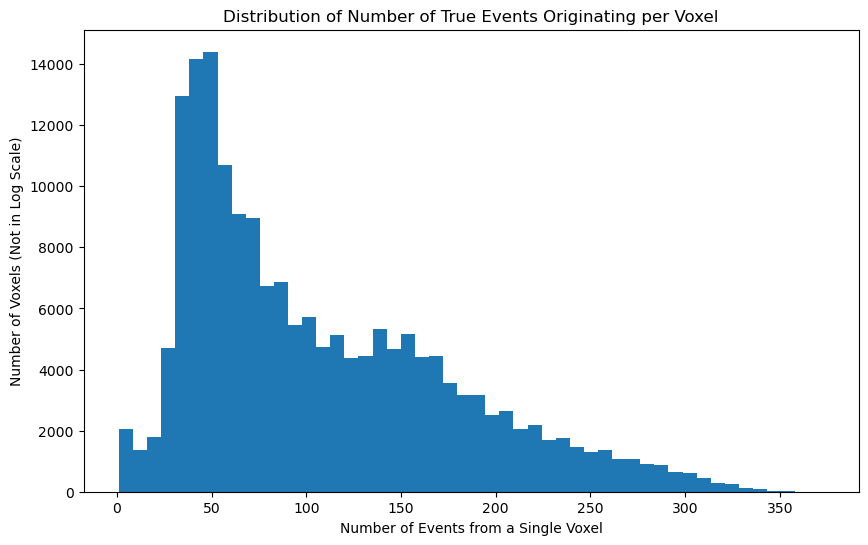

In [146]:
plt.figure(figsize=(10,6))
plt.hist(total_emissions_per_voxel.values, bins=50, log=False) # Use log scale for y-axis
plt.title("Distribution of Number of True Events Originating per Voxel")
plt.xlabel("Number of Events from a Single Voxel")
plt.ylabel("Number of Voxels (Not in Log Scale)")
plt.show()

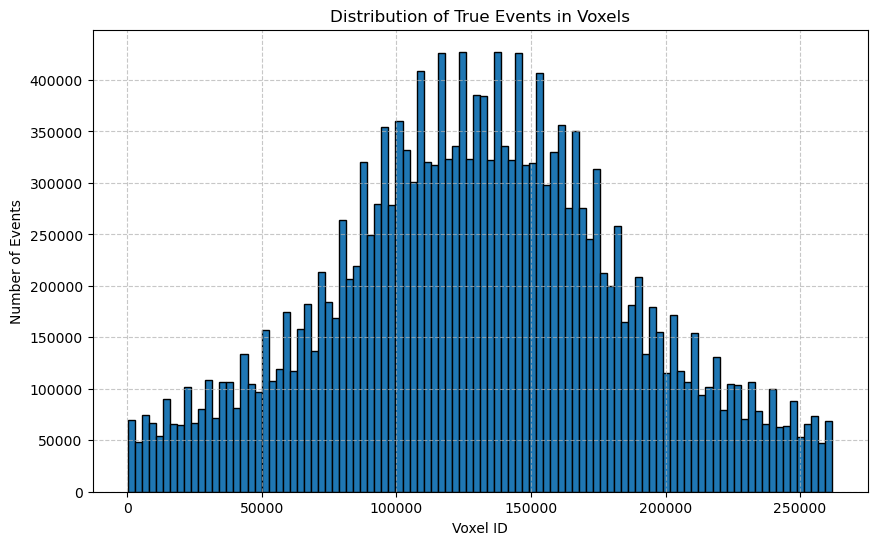

In [147]:
plt.figure(figsize=(10, 6))
plt.hist(df_true['voxel_id'], bins=min(TOTAL_VOXELS, 100), edgecolor='black')
plt.title('Distribution of True Events in Voxels')
plt.xlabel('Voxel ID')
plt.ylabel('Number of Events')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 4. Build System Matrix (Counts)

```
This matrix will have:
Rows: Flattened sinogram bins (theta_idx, s_idx)
Columns: Voxel IDs (voxel_id)
Value: Number of times an event from a voxel was detected in a sinogram bin

We use LIL format for building, then convert to CSR.
We build it "transposed" for easier LIL construction based on (voxel_id, sinogram_bin)
then transpose it back to the standard (sinogram_bin, voxel_id) convention.
OR, we can build it directly with (sinogram_bin, voxel_id) but LIL construction is row-major.

Let's build it with (flattened_sinogram_bin, voxel_id) directly.
This requires one LIL matrix per theta, then vstack.

```
system_matrix_lil_by_theta = [
    lil_matrix((SINOGRAM_PARAMS["n_s"], TOTAL_VOXELS), dtype=np.int32)
    for _ in range(SINOGRAM_PARAMS["n_theta"])
]

CHUNK_SIZE = 10000*10
num_chunks = (len(df_true) - 1) // CHUNK_SIZE + 1

for i_chunk in range(num_chunks):
    
    start_idx = i_chunk * CHUNK_SIZE
    end_idx = min((i_chunk + 1) * CHUNK_SIZE, len(df_true))
    
    chunk_df = df_true.iloc[start_idx:end_idx]
    
    print(f"  Processing chunk {i_chunk+1}/{num_chunks} for system matrix ({len(chunk_df)} events)")

    for _, row in chunk_df.iterrows():
        
        # Determine theta_idx for sinogram bin
        theta_val = row['sinogramTheta']
        if theta_val >= 180.0 and SINOGRAM_PARAMS["n_theta"] <= 180:
             theta_val = theta_val % 180.0
        theta_idx = int(theta_val / 180.0 * SINOGRAM_PARAMS["n_theta"])
        theta_idx = max(0, min(SINOGRAM_PARAMS["n_theta"] - 1, theta_idx))

        # Determine s_idx for sinogram bin
        s_val = row['sinogramS']
        s_idx = int(
            (s_val - SINOGRAM_PARAMS["s_min"]) /
            (SINOGRAM_PARAMS["s_max"] - SINOGRAM_PARAMS["s_min"]) * SINOGRAM_PARAMS["n_s"]
        )
        s_idx = max(0, min(SINOGRAM_PARAMS["n_s"] - 1, s_idx))

        # Get the source voxel ID (column index for the system matrix)
        voxel_id_val = row['voxel_id']
        if pd.isna(voxel_id_val): continue # Should not happen if previous steps are correct
        voxel_id = int(voxel_id_val)

        if not (0 <= voxel_id < TOTAL_VOXELS): continue # Sanity check

        # Increment the count in the LIL matrix for the specific theta_idx
        # The LIL matrix system_matrix_lil_by_theta[theta_idx] has rows for s_idx and columns for voxel_id
        system_matrix_lil_by_theta[theta_idx][s_idx, voxel_id] += 1

system_matrix_counts = vstack(system_matrix_lil_by_theta, format='csr', dtype=np.float64)

In [148]:
# Initialize system_matrix_csr_by_theta
system_matrix_csr_by_theta = [None] * SINOGRAM_PARAMS["n_theta"]

CHUNK_SIZE = 100000  # Adjust based on GPU memory
num_chunks = (len(df_true) - 1) // CHUNK_SIZE + 1

for i_chunk in range(num_chunks):
    start_idx = i_chunk * CHUNK_SIZE
    end_idx = min((i_chunk + 1) * CHUNK_SIZE, len(df_true))
    chunk_df = df_true.iloc[start_idx:end_idx]
    #print(f"  Processing chunk {i_chunk+1}/{num_chunks} for system matrix ({len(chunk_df)} events)")

    # Transfer data to GPU
    theta_val = cp.array(chunk_df['sinogramTheta'].values)
    s_val = cp.array(chunk_df['sinogramS'].values)
    voxel_id = cp.array(chunk_df['voxel_id'].values, dtype=cp.int32)

    # Handle NaN voxel IDs
    valid_mask = ~cp.isnan(voxel_id)
    theta_val = theta_val[valid_mask]
    s_val = s_val[valid_mask]
    voxel_id = voxel_id[valid_mask].astype(cp.int32)

    # Sanity check for voxel_id
    valid_voxel_mask = (voxel_id >= 0) & (voxel_id < TOTAL_VOXELS)
    theta_val = theta_val[valid_voxel_mask]
    s_val = s_val[valid_voxel_mask]
    voxel_id = voxel_id[valid_voxel_mask]

    # Compute theta_idx
    theta_val = cp.where(theta_val >= 180.0, theta_val % 180.0, theta_val)
    theta_idx = (theta_val / 180.0 * SINOGRAM_PARAMS["n_theta"]).astype(cp.int32)
    theta_idx = cp.clip(theta_idx, 0, SINOGRAM_PARAMS["n_theta"] - 1)

    # Compute s_idx
    s_idx = (
        (s_val - SINOGRAM_PARAMS["s_min"]) /
        (SINOGRAM_PARAMS["s_max"] - SINOGRAM_PARAMS["s_min"]) * SINOGRAM_PARAMS["n_s"]
    ).astype(cp.int32)
    s_idx = cp.clip(s_idx, 0, SINOGRAM_PARAMS["n_s"] - 1)

    # For each unique theta_idx, create a sparse matrix
    unique_theta_idx = cp.unique(theta_idx)
    
    for theta in unique_theta_idx.get():  # Transfer to CPU for iteration
        # Create mask for current theta
        theta_mask = theta_idx == theta
        s_idx_theta = s_idx[theta_mask]
        voxel_id_theta = voxel_id[theta_mask]

        # Create COO matrix for this theta
        if s_idx_theta.size == 0:  # Handle empty data
            matrix = csr_matrix((SINOGRAM_PARAMS["n_s"], TOTAL_VOXELS), dtype=np.float64)  # Use csr_matrix class
        else:
            data = cp.ones(s_idx_theta.shape[0], dtype=cp.float64)
            row = s_idx_theta
            col = voxel_id_theta
            coo_matrix = cp_sparse.coo_matrix(
                (data, (row, col)),
                shape=(SINOGRAM_PARAMS["n_s"], TOTAL_VOXELS),
                dtype=cp.float64
            )
            # Convert to CSR and transfer to CPU
            matrix = coo_matrix.tocsr().get()  # .get() converts to SciPy CSR

        # Store or accumulate
        if system_matrix_csr_by_theta[theta] is None:
            system_matrix_csr_by_theta[theta] = matrix
        else:
            system_matrix_csr_by_theta[theta] += matrix

# Convert GPU CSR matrices to CPU CSR matrices and stack
system_matrix_csr_by_theta = [
    m if m is not None else csr_matrix((SINOGRAM_PARAMS["n_s"], TOTAL_VOXELS), dtype=np.float64)  # Use csr_matrix class
    for m in system_matrix_csr_by_theta
]

# Verify shapes
n_cols = TOTAL_VOXELS
for i, m in enumerate(system_matrix_csr_by_theta):
    if not issparse(m) or not isinstance(m, csr_matrix):  # Check against scipy.sparse.csr_matrix
        raise ValueError(f"Matrix {i} is not a valid SciPy CSR matrix: {type(m)}")
    if m.shape != (SINOGRAM_PARAMS["n_s"], n_cols):
        raise ValueError(f"Matrix {i} has incompatible shape {m.shape}")

# Stack the matrices
if not system_matrix_csr_by_theta:
    raise ValueError("No valid matrices to stack")
system_matrix_counts = vstack(system_matrix_csr_by_theta, format='csr', dtype=np.float64)

In [149]:
print(f"System matrix (counts) => Shape: (N_Sinogram_Bins, N_Voxels) = {system_matrix_counts.shape}")
assert system_matrix_counts.shape == (N_SINOGRAM_BINS_TOTAL, TOTAL_VOXELS)

System matrix (counts) => Shape: (N_Sinogram_Bins, N_Voxels) = (23040, 262144)


### 5. Normalize System Matrix

In [150]:
total_emissions_per_voxel = df_true['voxel_id'].value_counts()

In [151]:
system_matrix_A = system_matrix_counts.copy().astype(np.float64)

```
for i in range(len(system_matrix_A.data)):
    voxel_col_idx = system_matrix_A.indices[i] # This is the voxel_id for the current data point

    if voxel_col_idx in total_emissions_per_voxel:
        normalization_factor = total_emissions_per_voxel[voxel_col_idx]
        if normalization_factor > 0:
            system_matrix_A.data[i] /= normalization_factor
        else:
            # This voxel had 0 emissions recorded in df_true but has entry in matrix (should not happen with true events)
            system_matrix_A.data[i] = 0.0
    else:
        # This voxel_id was not in total_emissions_per_voxel (meaning 0 emissions from it)
        # but it has a non-zero entry in the system_matrix_counts. This implies an issue
        # or that the voxel was empty. Set its contribution to 0.
        system_matrix_A.data[i] = 0.0

In [152]:
# Compute total_emissions_per_voxel as the column sums of system_matrix_A
total_emissions_per_voxel = np.array(system_matrix_A.sum(axis=0)).flatten()

# Debug: Verify total_emissions_per_voxel
print("total_emissions_per_voxel size:", total_emissions_per_voxel.size)
print("total_emissions_per_voxel non-zero count:", np.count_nonzero(total_emissions_per_voxel))
print("total_emissions_per_voxel max value:", np.max(total_emissions_per_voxel))

# Convert system_matrix_A to CuPy sparse CSR matrix
system_matrix_A_gpu = cp_sparse.csr_matrix((cp.asarray(system_matrix_A.data),
                                           cp.asarray(system_matrix_A.indices),
                                           cp.asarray(system_matrix_A.indptr)),
                                          shape=system_matrix_A.shape)

# Convert total_emissions_per_voxel to CuPy array
normalization_factors = cp.asarray(total_emissions_per_voxel, dtype=cp.float64)

# Vectorized normalization on GPU
norm_factors = normalization_factors[system_matrix_A_gpu.indices]
system_matrix_A_gpu.data = cp.where(norm_factors > 0, system_matrix_A_gpu.data / norm_factors, 0.0)

# Transfer result back to CPU
system_matrix_A.data = cp.asnumpy(system_matrix_A_gpu.data)

total_emissions_per_voxel size: 262144
total_emissions_per_voxel non-zero count: 181000
total_emissions_per_voxel max value: 373.0


### 6. Save System Matrix

In [153]:
output_filename_sm = "system_matrix_A.npz"
print(f"Saving system matrix to {output_filename_sm}...")

save_npz(output_filename_sm, system_matrix_A)
print(f"System Matrix saved. Shape: {system_matrix_A.shape}")

mem_usage_bytes_sm = (system_matrix_A.data.nbytes +
                      system_matrix_A.indices.nbytes +
                      system_matrix_A.indptr.nbytes)
mem_usage_mb_sm = mem_usage_bytes_sm / (1024**2)

print(f"Approximate memory usage of sparse system matrix: {mem_usage_mb_sm:.2f} MB")
print(f"Number of non-zero elements in system matrix: {system_matrix_A.nnz}")

total_elements_sm = system_matrix_A.shape[0] * system_matrix_A.shape[1]
if total_elements_sm > 0:
    sparsity_pct_sm = (system_matrix_A.nnz / total_elements_sm) * 100
    print(f"Sparsity of system matrix: {sparsity_pct_sm:.6f}%")
else:
    print("Sparsity: N/A (empty matrix)")

Saving system matrix to system_matrix_A.npz...
System Matrix saved. Shape: (23040, 262144)
Approximate memory usage of sparse system matrix: 168.47 MB
Number of non-zero elements in system matrix: 14713057
Sparsity of system matrix: 0.243602%


### Difference between Sinogram and System Matrix

**Sinogram Matrix (p)**

- For 2D parallel beam geometry (common example): Rows correspond to detector positions (s), and columns correspond to projection angles (θ). So, it's an (num_detector_bins x num_angles) matrix.
- More generally, it's a collection of M distinct measurements. So, p can be thought of as a long list (vector) of these M measurement values.

**System Matrix (A)**

Element A[i, j] represents the contribution of voxel j in the object to the measurement i in the sinogram.
- In PET: A[i, j] is the probability that an emission from voxel j is detected in sinogram bin i.
- In CT (transmission): A[i, j] is the length of intersection of the X-ray beam corresponding to sinogram bin i with voxel j.


* Rows: Correspond to the sinogram bins/measurements (M of them).
* Columns: Correspond to the image voxels (N of them).
So, it's an M x N matrix.

**Fundamental Equation:**

The relationship is often expressed as:

p = A * f + noise

- p (Sinogram vector, M x 1): What the scanner measures.
- A (System Matrix, M x N): How the scanner works.
- f (Image vector, N x 1): What's inside the object (unknown).
- noise: Imperfections in the measurement.

A[i,j] ≈ (Number of detected events in bin 'i' originating from voxel 'j') / (Total number of events simulated/processed originating from voxel 'j')

### Verifying Correctness

In [154]:
if (system_matrix_A.data < 0).any():
    print("ERROR: System matrix contains negative values!")
else:
    print("Sanity Check 1: All system matrix elements are non-negative - PASSED")

Sanity Check 1: All system matrix elements are non-negative - PASSED


In [155]:
total_detection_efficiency_per_voxel = np.array(system_matrix_A.sum(axis=0)).flatten()
if (total_detection_efficiency_per_voxel > 1.00001).any(): # Allow for tiny float precision issues
    print("WARNING: Sum of probabilities for some voxels exceeds 1. Check normalization.")
    print(f"Max sum found: {total_detection_efficiency_per_voxel.max()}")
else:
    print("Sanity Check 2: Sum of probabilities per voxel (detection efficiency) <= 1 - PASSED (for non-zero voxels)")

Sanity Check 2: Sum of probabilities per voxel (detection efficiency) <= 1 - PASSED (for non-zero voxels)
